In [107]:
# import requests
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [101]:
file = "nomes_br.csv"
words = []
with open(file, 'r', encoding='utf-8') as f:
    words = f.read().lower().splitlines()

file = "names.txt"
with open(file, 'r', encoding='utf-8') as f:
    for w in f.read().lower().splitlines():
        words.append(w) 
words = list(dict.fromkeys(words))
len(words), words[:10]

(57750,
 ['adao',
  'adelina',
  'adelson',
  'ademar',
  'ademir',
  'adenilson',
  'adilson',
  'adriana',
  'adriano',
  'adriele'])

In [102]:
#build the vocabulary os chars and mapping to/from integers
chars = ['.']+sorted(list(set(''.join(words))))
ctoi = {c:i for i,c in enumerate(chars)}
itoc = {i:c for c,i in ctoi.items()}
vocab_size = len(itoc)
print(itoc)
print(vocab_size)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
27


In [103]:
# build the dataset

block_size = 3
def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = ctoi[ch]
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# training split, dev/validation split, test split
# 80%, 10% , 10%
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([348607, 3]) torch.Size([348607])
torch.Size([43537, 3]) torch.Size([43537])
torch.Size([43738, 3]) torch.Size([43738])


In [104]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [111]:
g = torch.Generator().manual_seed(2147483647)

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x: torch.Tensor):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.std(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        #
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __init__(self) -> None:
        self.weight = None

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

n_emb = 10
n_hidden = 100

C = torch.randn((vocab_size, n_emb), generator=g)
layers = [
    Linear(n_emb * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    # Linear(          n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    # Linear(          n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    # Linear(          n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1

    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

16424


In [112]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

In [113]:
for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # foward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < max_steps/2 else (0.01 if i < max_steps * 0.75 else 0.005) # lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])

    # if i> 1000:
    #     break # debug purpose

print(loss.item())

      0/ 200000: 3.3066
  10000/ 200000: 2.4450
  20000/ 200000: 2.3570
  30000/ 200000: 2.4723
  40000/ 200000: 2.1361
  50000/ 200000: 2.0158
  60000/ 200000: 2.3365
  70000/ 200000: 2.2503
  80000/ 200000: 1.9482
  90000/ 200000: 1.9168
 100000/ 200000: 2.1775
 110000/ 200000: 2.0197
 120000/ 200000: 2.0688
 130000/ 200000: 1.7886
 140000/ 200000: 2.0678
 150000/ 200000: 2.1577
 160000/ 200000: 2.3229
 170000/ 200000: 2.0717
 180000/ 200000: 2.4984
 190000/ 200000: 1.9900
2.3544411659240723


layer 2 (      Tanh): mean +0.02, std 0.78, saturated 28.28%
layer 5 (      Tanh): mean +0.01, std 0.84, saturated 38.28%


Text(0.5, 1.0, 'activation distribution')

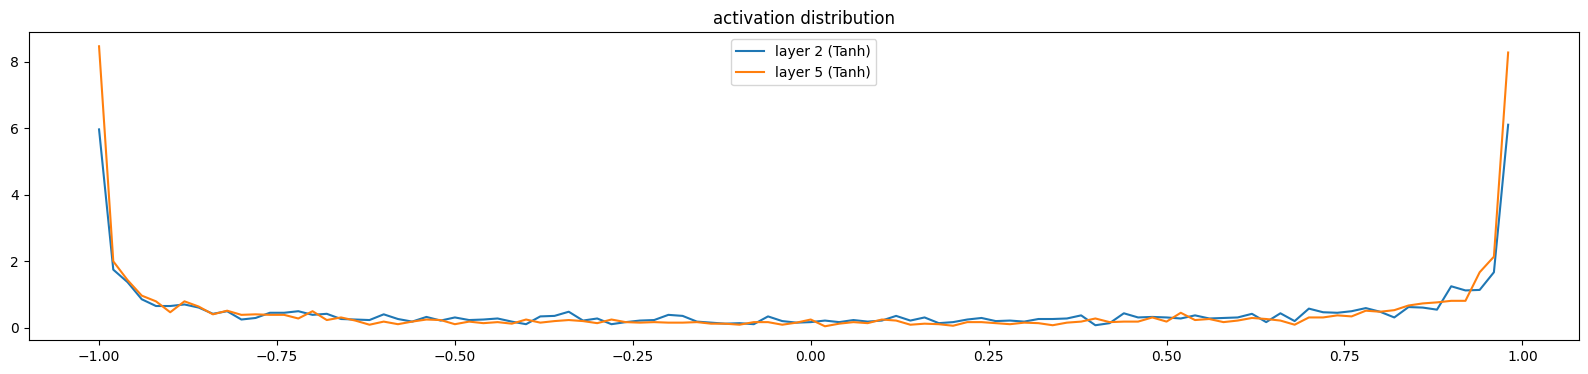

In [114]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 4.534469e-03
layer 5 (      Tanh): mean -0.000000, std 4.110149e-03


Text(0.5, 1.0, 'gradient distribution')

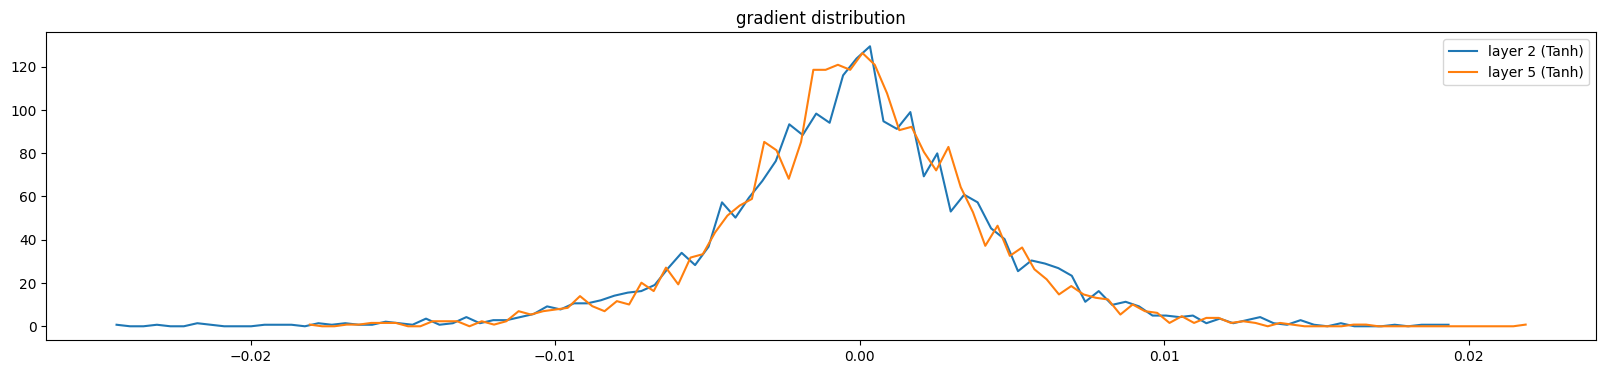

In [115]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution')

weigth:   (27, 10) | mean -0.000000 | std 1.987612e-02 | grad:data ratio 1.732542e-02
weigth:  (30, 100) | mean -0.000011 | std 1.079555e-02 | grad:data ratio 2.422974e-02
weigth: (100, 100) | mean +0.000005 | std 7.017564e-03 | grad:data ratio 2.573288e-02
weigth:  (100, 27) | mean +0.000279 | std 1.091006e-02 | grad:data ratio 3.135365e-02


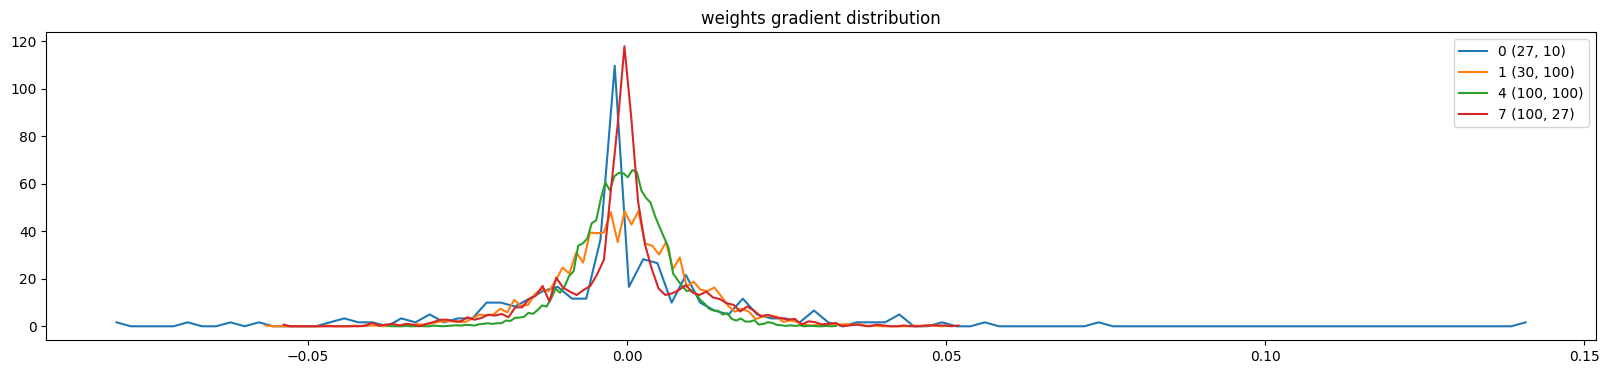

In [117]:
plt.figure(figsize=(20,4))
legends=[]
for i, p in enumerate(parameters):
    if p.ndim == 2:
        t = p.grad
        print('weigth: %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/ p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');
              

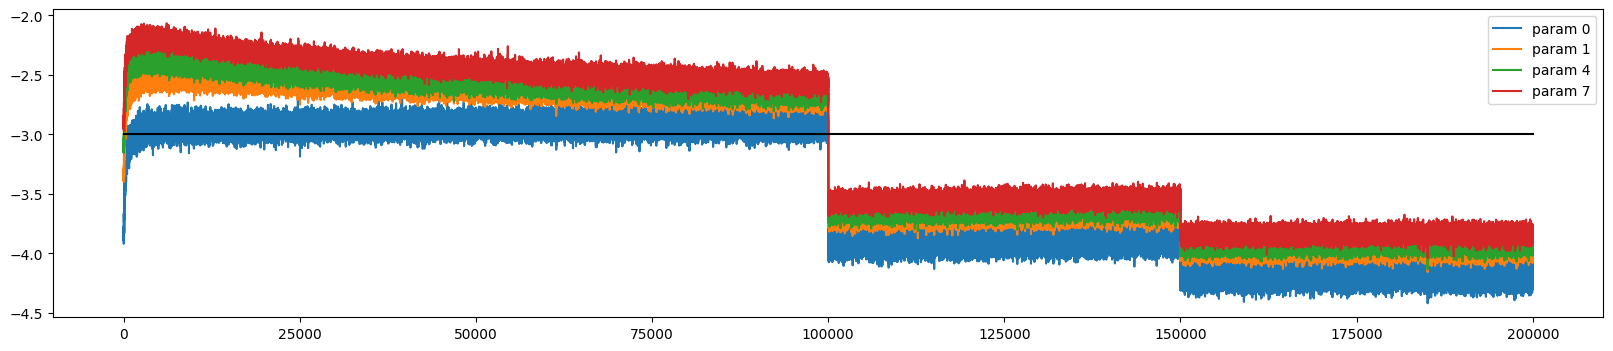

In [118]:
plt.figure(figsize=(20,4))
legends=[]
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param {i}')
plt.plot([0,len(ud)], [-3, -3], 'k')
plt.legend(legends);

In [119]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.0783212184906006
val 2.106351137161255


In [126]:
# sample from model

g1 = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1, generator=g1).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itoc[i] for i in out))